# Project no. 2 Missing Data

**Author: Filip Kołodziejczyk 313019**


## Introduction

I decided to work on the [Power Consumption of Tetouan City dataset](https://archive.ics.uci.edu/dataset/849/power+consumption+of+tetouan+city) which *is related to power consumption of three different distribution networks of Tetouan city which is located in north Morocco.* The goal of the task is to create a regression model predicting the power consumption of the city based on the data provided in the dataset. The model based on full data will be compared with the ones with missing data introduced, to see how methods of handling missing data affect the model's performance.

## Loading the data

First I load the dataset and check its overall structure.

In [1]:
import pandas as pd
from IPython.display import Markdown, display
from ucimlrepo import fetch_ucirepo

repo_name = "Power Consumption of Tetouan City"
repo = fetch_ucirepo(repo_name)

In [2]:
variables = pd.DataFrame(repo.variables)
display(Markdown(f"**Variables Overview**"), variables)

X = repo.data.features
display(Markdown(f"**Features Overview**"), X)

y = repo.data.targets
display(Markdown(f"**Target Variables Overview**"), y)

**Variables Overview**

,name,role,type,demographic,description,units,missing_values
0,DateTime,Feature,Date,None,Each ten minutes,None,no
1,Temperature,Feature,Continuous,None,Weather Temperature of Tetouan city,None,no
2,Humidity,Feature,Continuous,None,Weather Humidity of Tetouan city,None,no
3,Wind Speed,Feature,Continuous,None,Wind speed of Tetouan city,None,no
4,general diffuse flows,Feature,Continuous,None,general diffuse flows,None,no
5,diffuse flows,Feature,Continuous,None,diffuse flows,None,no
6,Zone 1 Power Consumption,Target,Continuous,None,power consumption of zone 1 of Tetouan city,None,no
7,Zone 2 Power Consumption,Target,Continuous,None,power consumption of zone 2 of Tetouan city,None,no
8,Zone 3 Power Consumption,Target,Continuous,None,power consumption of zone 3 of Tetouan city,None,no


**Features Overview**

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085
...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089


**Target Variables Overview**

,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,34055.69620,16128.87538,20240.96386
1,29814.68354,19375.07599,20131.08434
2,29128.10127,19006.68693,19668.43373
3,28228.86076,18361.09422,18899.27711
4,27335.69620,17872.34043,18442.40964
...,...,...,...
52411,31160.45627,26857.31820,14780.31212
52412,30430.41825,26124.57809,14428.81152
52413,29590.87452,25277.69254,13806.48259
52414,28958.17490,24692.23688,13512.60504


As we may see, the dataset consists of 6 features, where all of them are numerical except date (which can be encoded easily). The target variable is a tuple of 3 values, which represent the power consumption of 3 different distribution networks. Dataset consists of over 50k samples, which is a good amount to be able to introduce missing data without losing too much information. Since the goal of the task is focused on handling missing data, I will simplify problem from multivariate regression to univariate regression, by predicting the sum of power consumption for all three zones.

## Data Analysis and Feature Engineering

Before I will select a suitable model for the task, I will perform some data analysis to understand the data nature better. Based on the analysis I will decide if any feature engineering is needed,and apply it if necessary.

### Data formatting

Before I will proceed with the analysis, I will ensure that the data is formatted correctly and merge the target variables. I will convert the datetime column to a datetime object and set it as an index.

In [3]:
y = y.sum(axis=1).rename("Total Power Consumption")
data = pd.concat([X, y], axis=1)

display(Markdown(f"**Data Types**"), data.dtypes)

**Data Types**

DateTime                    object
Temperature                float64
Humidity                   float64
Wind Speed                 float64
general diffuse flows      float64
diffuse flows              float64
Total Power Consumption    float64
dtype: object

We can see that each feature except the *DateTime* is correctly formatted as a float. I will convert *DateTime* to a datetime object.

In [4]:
pd.options.mode.chained_assignment = None
data["DateTime"] = pd.to_datetime(data["DateTime"])

display(Markdown(f"**Data Types**"), data.dtypes)

**Data Types**

DateTime                   datetime64[ns]
Temperature                       float64
Humidity                          float64
Wind Speed                        float64
general diffuse flows             float64
diffuse flows                     float64
Total Power Consumption           float64
dtype: object

I also decided to split the date into separate columns, as it may be useful for the model to have information about the time of the day, day of the week, etc., independently. It is often that those matter (and the full datetime hides this information). Moreover, I apply cyclical transformation to the time features, to keep their periodic nature (e.g. 23:00 is closer to 00:00 than to 12:00).

In [5]:
import numpy as np

sin_transform = lambda x: np.sin(2 * np.pi * x / max(x))
cos_transform = lambda x: np.cos(2 * np.pi * x / max(x))

data["year_sin"] = sin_transform(data["DateTime"].dt.year)
data["year_cos"] = cos_transform(data["DateTime"].dt.year)
data["month_sin"] = sin_transform(data["DateTime"].dt.month)
data["month_cos"] = cos_transform(data["DateTime"].dt.month)
data["day_sin"] = sin_transform(data["DateTime"].dt.day)
data["day_cos"] = cos_transform(data["DateTime"].dt.day)
data["hour_sin"] = sin_transform(data["DateTime"].dt.hour)
data["hour_cos"] = cos_transform(data["DateTime"].dt.hour)
data["minute_sin"] = sin_transform(data["DateTime"].dt.minute)
data["minute_cos"] = cos_transform(data["DateTime"].dt.minute)
data["weekday_sin"] = sin_transform(data["DateTime"].dt.weekday)
data["weekday_cos"] = cos_transform(data["DateTime"].dt.weekday)

data.drop(("DateTime"), axis=1, inplace=True)
new_order = [col for col in data.columns if col != "Total Power Consumption"] + [
    "Total Power Consumption"
]
data = data[new_order]

display(Markdown(f"**Data Overview**"), data)

**Data Overview**

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,weekday_sin,weekday_cos,Total Power Consumption
0,6.559,73.8,0.083,0.051,0.119,-2.449294e-16,1.0,5.000000e-01,0.866025,0.201299,0.97953,0.000000e+00,1.0,0.000000e+00,1.000000,-2.449294e-16,1.0,70425.53544
1,6.414,74.5,0.083,0.070,0.085,-2.449294e-16,1.0,5.000000e-01,0.866025,0.201299,0.97953,0.000000e+00,1.0,9.510565e-01,0.309017,-2.449294e-16,1.0,69320.84387
2,6.313,74.5,0.080,0.062,0.100,-2.449294e-16,1.0,5.000000e-01,0.866025,0.201299,0.97953,0.000000e+00,1.0,5.877853e-01,-0.809017,-2.449294e-16,1.0,67803.22193
3,6.121,75.0,0.083,0.091,0.096,-2.449294e-16,1.0,5.000000e-01,0.866025,0.201299,0.97953,0.000000e+00,1.0,-5.877853e-01,-0.809017,-2.449294e-16,1.0,65489.23209
4,5.921,75.7,0.081,0.048,0.085,-2.449294e-16,1.0,5.000000e-01,0.866025,0.201299,0.97953,0.000000e+00,1.0,-9.510565e-01,0.309017,-2.449294e-16,1.0,63650.44627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.201299,0.97953,-2.449294e-16,1.0,9.510565e-01,0.309017,-8.660254e-01,0.5,72798.08659
52412,6.947,72.6,0.082,0.051,0.093,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.201299,0.97953,-2.449294e-16,1.0,5.877853e-01,-0.809017,-8.660254e-01,0.5,70983.80786
52413,6.900,72.8,0.086,0.084,0.074,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.201299,0.97953,-2.449294e-16,1.0,-5.877853e-01,-0.809017,-8.660254e-01,0.5,68675.04965
52414,6.758,73.0,0.080,0.066,0.089,-2.449294e-16,1.0,-2.449294e-16,1.000000,-0.201299,0.97953,-2.449294e-16,1.0,-9.510565e-01,0.309017,-8.660254e-01,0.5,67163.01682


### Exploratory Data Analysis

I will start with descriptive statistics and visualizations, possibly to identify some patterns in the data.

**Data descriptive statistics**

,count,mean,std,min,25%,50%,75%,max
Temperature,52416.0,1.881002e+01,5.815476e+00,3.247000e+00,1.441000e+01,1.878000e+01,2.289000e+01,4.001000e+01
Humidity,52416.0,6.825952e+01,1.555118e+01,1.134000e+01,5.831000e+01,6.986000e+01,8.140000e+01,9.480000e+01
Wind Speed,52416.0,1.959489e+00,2.348862e+00,5.000000e-02,7.800000e-02,8.600000e-02,4.915000e+00,6.483000e+00
general diffuse flows,52416.0,1.826966e+02,2.644010e+02,4.000000e-03,6.200000e-02,5.035500e+00,3.196000e+02,1.163000e+03
diffuse flows,52416.0,7.502802e+01,1.242109e+02,1.100000e-02,1.220000e-01,4.456000e+00,1.010000e+02,9.360000e+02
year_sin,52416.0,-2.449294e-16,4.930428e-32,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16,-2.449294e-16
year_cos,52416.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
month_sin,52416.0,-5.395884e-03,7.066071e-01,-1.000000e+00,-8.660254e-01,-2.449294e-16,5.000000e-01,1.000000e+00
month_cos,52416.0,-5.126443e-03,7.075804e-01,-1.000000e+00,-8.660254e-01,-1.836970e-16,5.915064e-01,1.000000e+00
day_sin,52416.0,1.636413e-03,7.144631e-01,-9.987165e-01,-7.247928e-01,-2.449294e-16,7.247928e-01,9.987165e-01


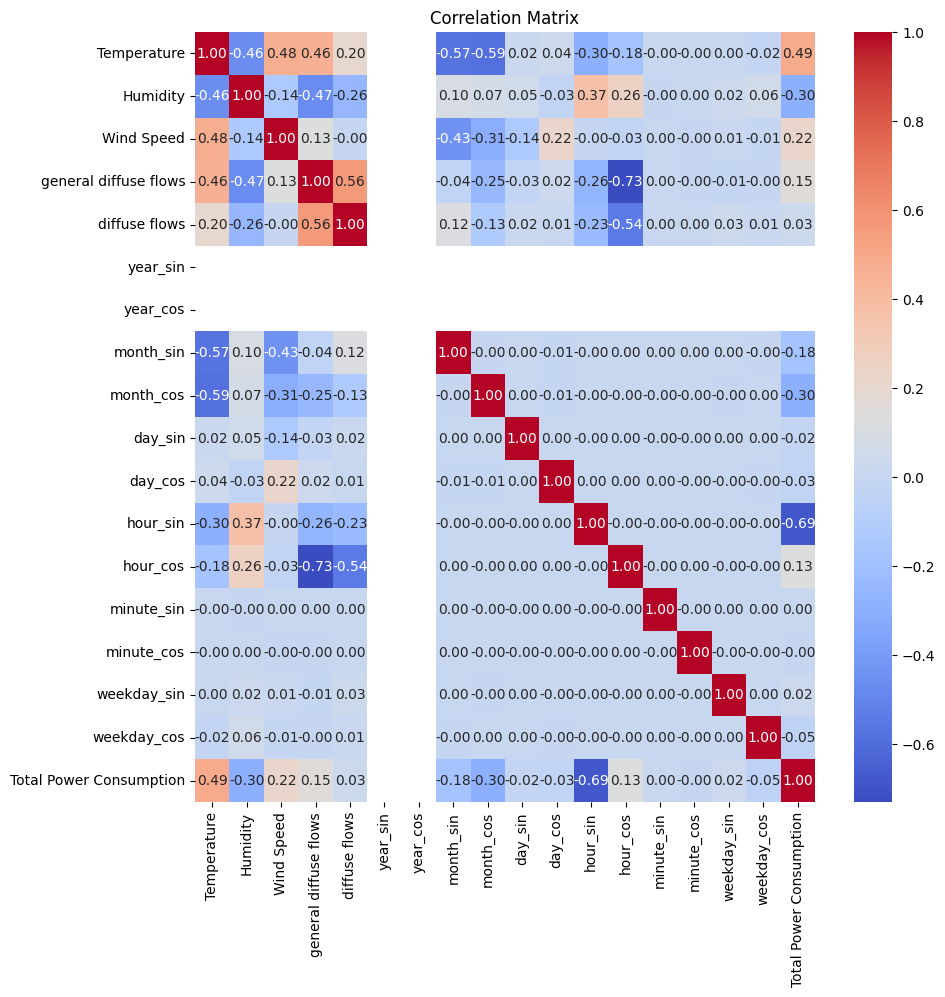

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

display(Markdown(f"**Data descriptive statistics**"), data.describe().T)

corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
ax.set(xlabel="", ylabel="")
plt.title("Correlation Matrix")
plt.show()

Correlation matrix indicates that *Year* feature does not hold any values as the data was gathered over the span of one year. Thus, I will remove it. *Minute* feature show no correlation with target variable at all. Hence, I will remove it too. No other features show near perfect positive or negative relations to consider removing them. I will also check for multicollinearity.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data.drop("year_sin", axis=1, inplace=True)
data.drop("year_cos", axis=1, inplace=True)
data.drop("minute_sin", axis=1, inplace=True)
data.drop("minute_cos", axis=1, inplace=True)
X = data[data.columns[:-1]]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(Markdown(f"**Variance Inflation Factor (VIF)**"), vif_data)

**Variance Inflation Factor (VIF)**

,feature,VIF
0,Temperature,18.973682
1,Humidity,12.921224
2,Wind Speed,2.625701
3,general diffuse flows,5.218264
4,diffuse flows,2.280243
5,month_sin,1.752841
6,month_cos,1.500873
7,day_sin,1.035549
8,day_cos,1.070470
9,hour_sin,1.456449


It seems that temperature and humidity have high multicollinearity, yet I won't get rid of them, since they seem to me as a key features in this task (I will monitor if it will cause any problems later).

### Data Quality Check

Now I will confirm if indeed, no missing values are present in the dataset. I will also check for outliers, which could possibly skew the results.

In [8]:
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
display(Markdown(f"**Missing Data**"), missing_data)

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data < lower_bound) | (data > upper_bound)].count()
outliers = outliers * 100 / data.shape[0]
display(Markdown(f"**Outliers (%)**"), outliers.round(2))

**Missing Data**

Series([], dtype: int64)

**Outliers (%)**

Temperature                0.27
Humidity                   0.56
Wind Speed                 0.00
general diffuse flows      4.42
diffuse flows              8.72
month_sin                  0.00
month_cos                  0.00
day_sin                    0.00
day_cos                    0.00
hour_sin                   0.00
hour_cos                   0.00
weekday_sin                0.00
weekday_cos                0.00
Total Power Consumption    0.29
dtype: float64

Indeed no missing values, as the dataset description stated. Only *diffuse flows* features has significant number of outliers, but according to the nature of the energy consumption, it could be expected - spikes may occur due to various reasons [[Variability in electricity consumption by category of consumer: The impact on electricity load profiles](https://doi.org/10.1016/j.ijepes.2022.108852)].

### Linearity Check

Finally, before I will decide on the model, I will check if the features are in linear relationship with the target variable (correlation somehow indicates that, but I want a bit more visual check).

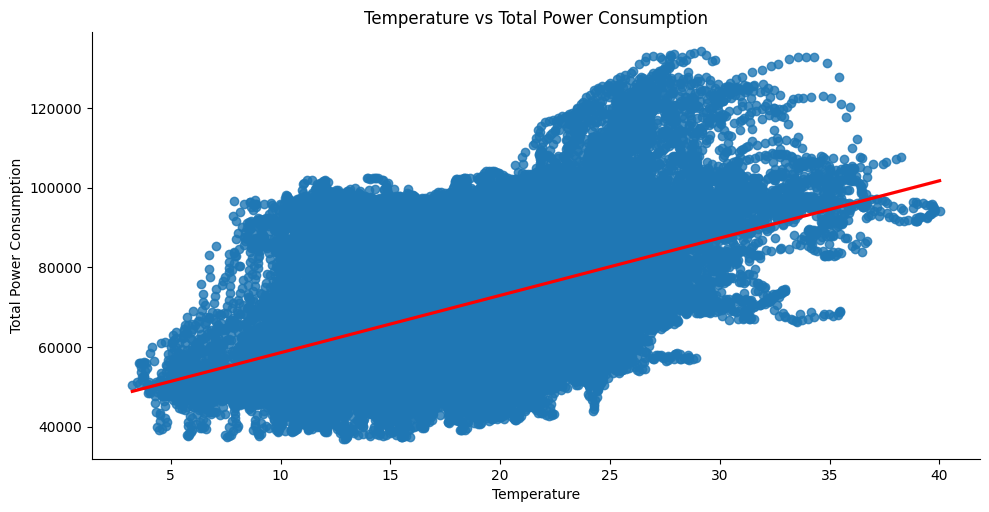

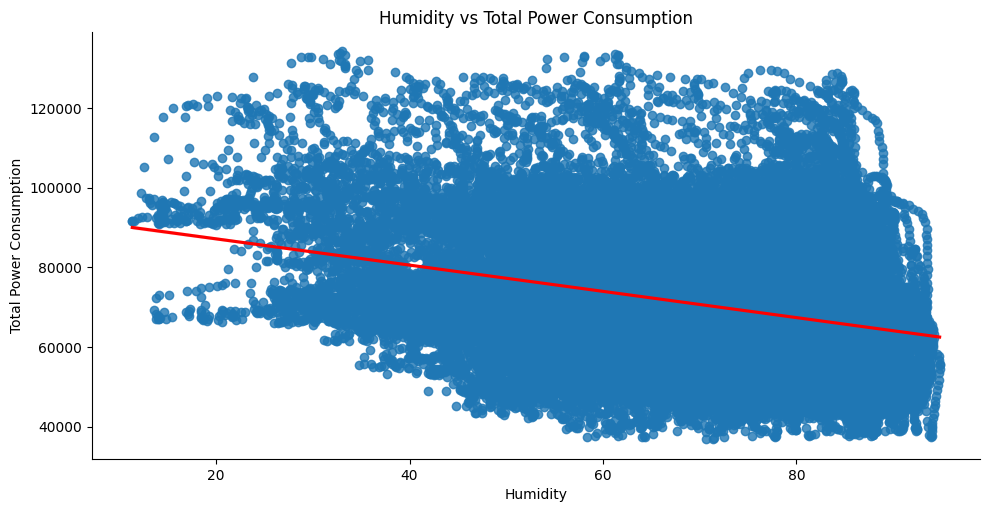

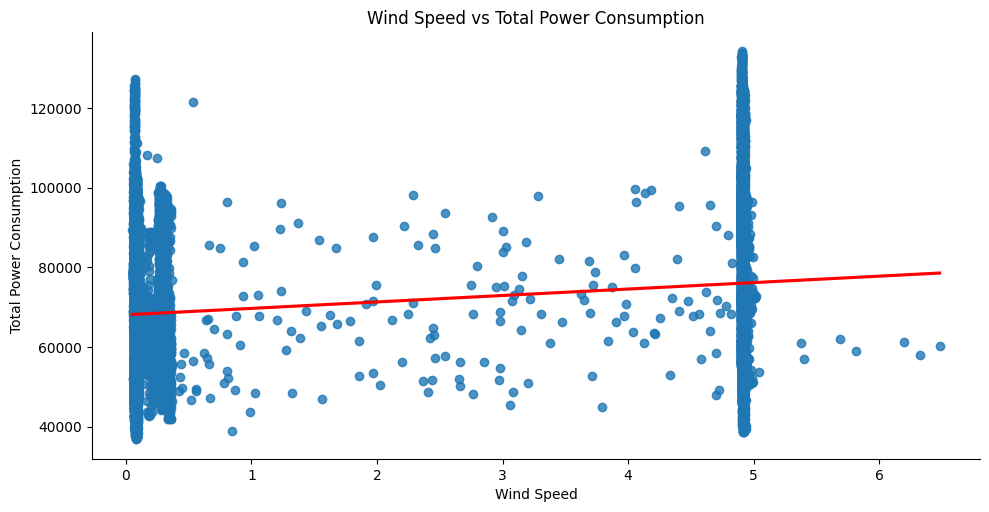

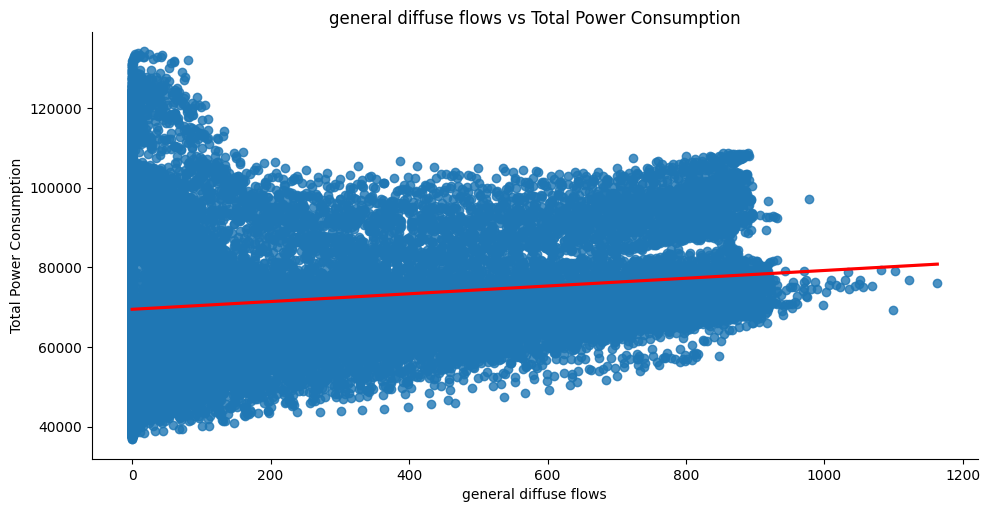

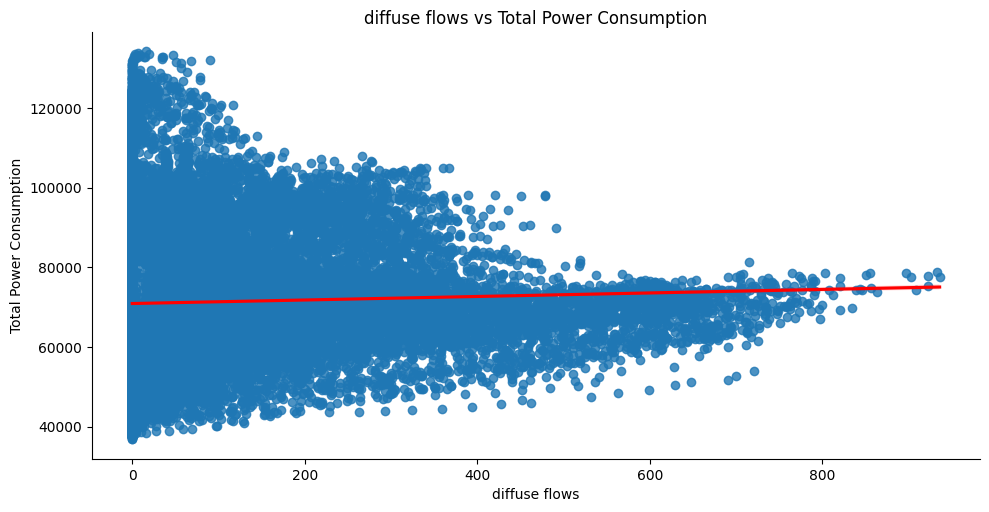

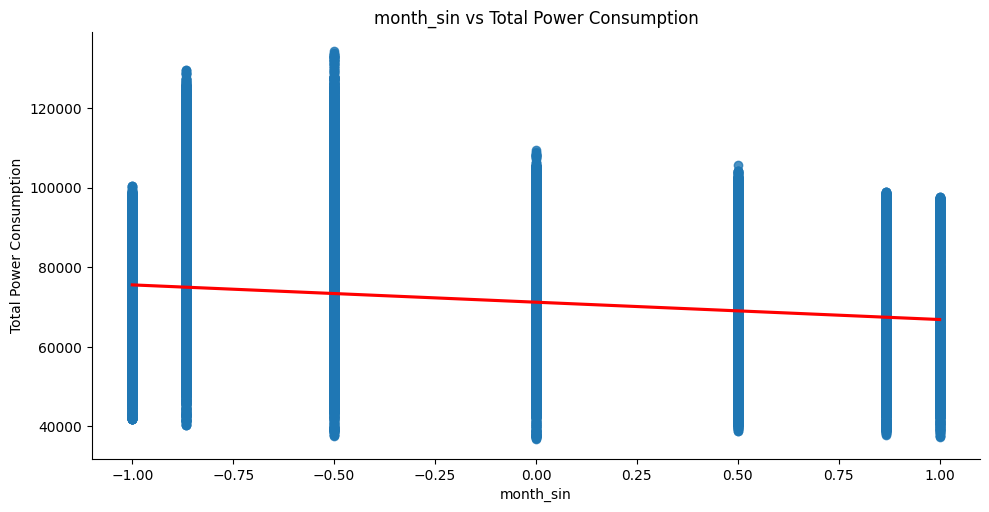

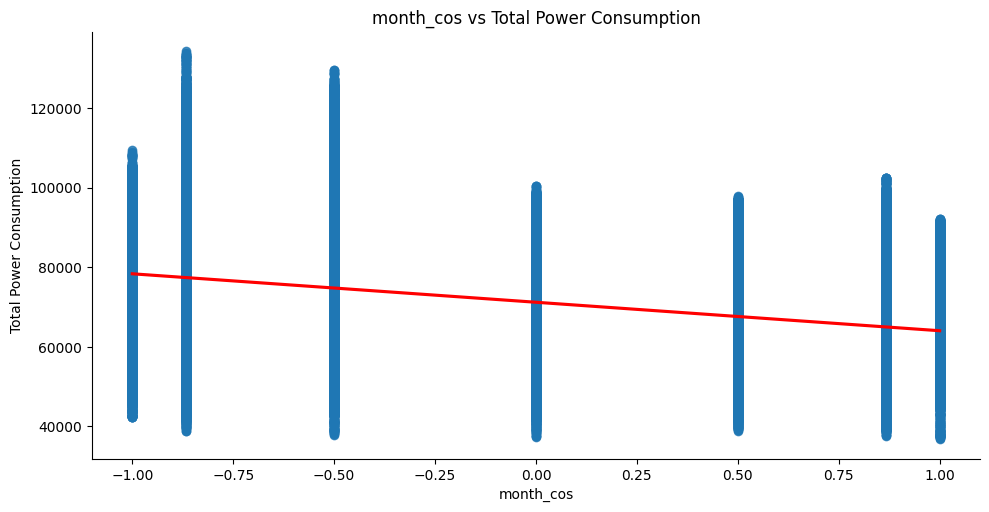

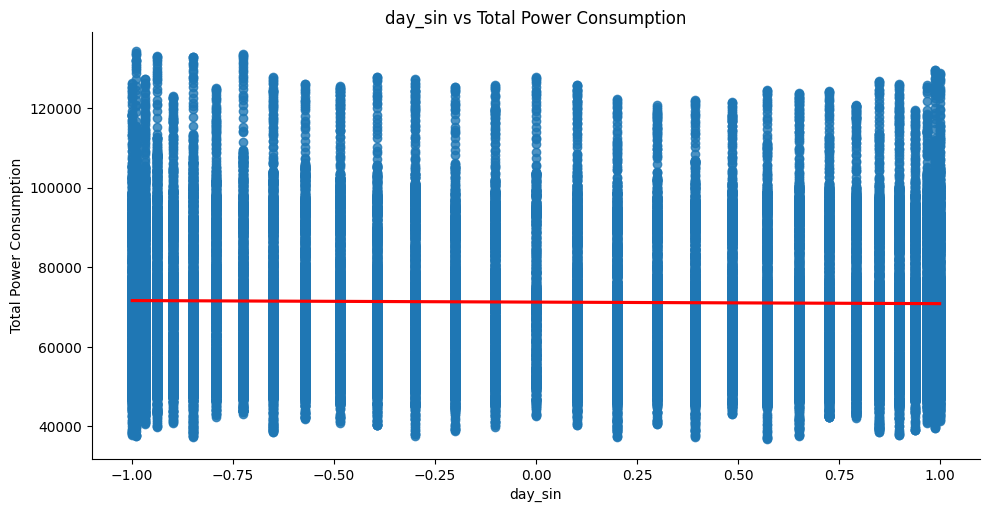

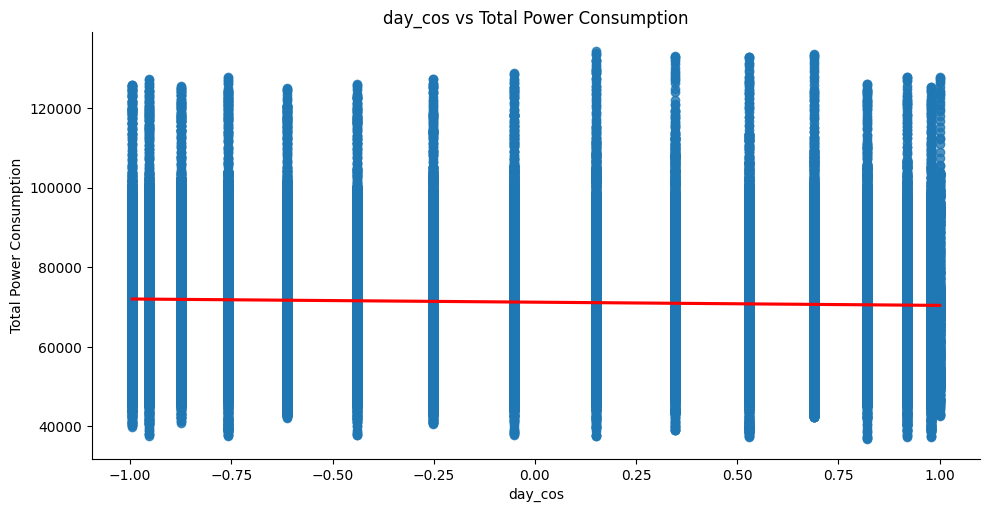

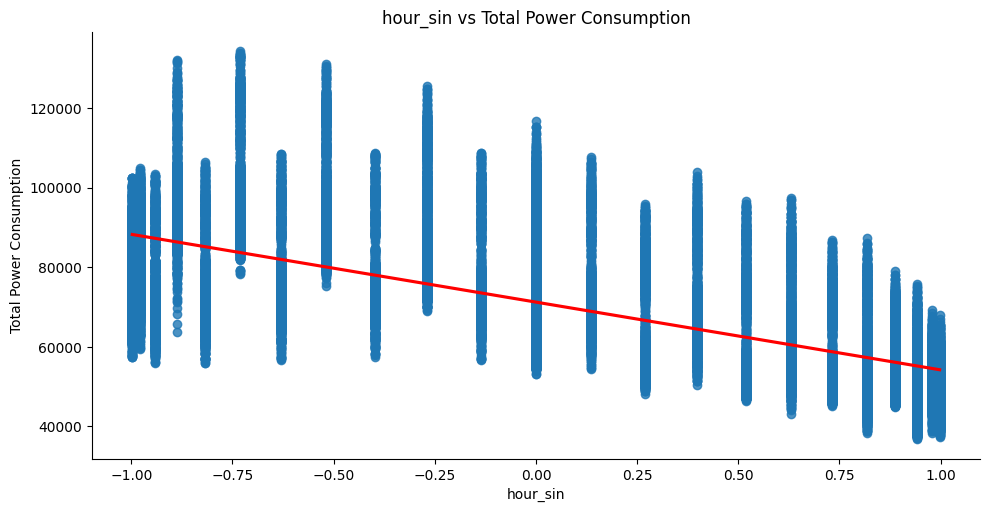

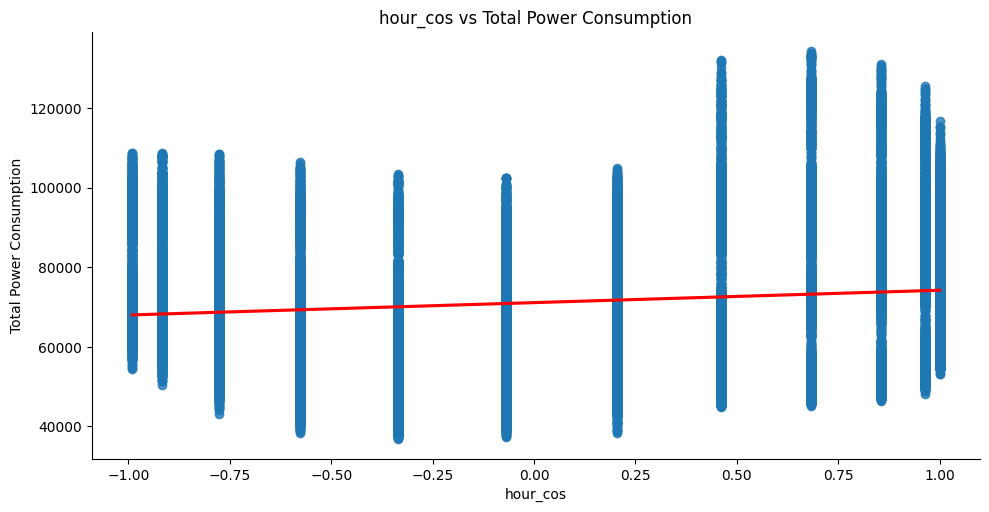

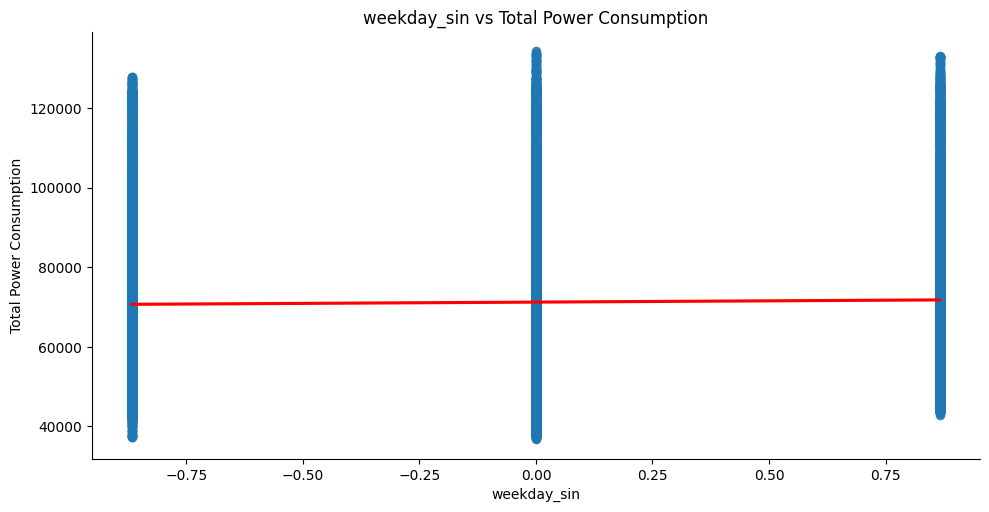

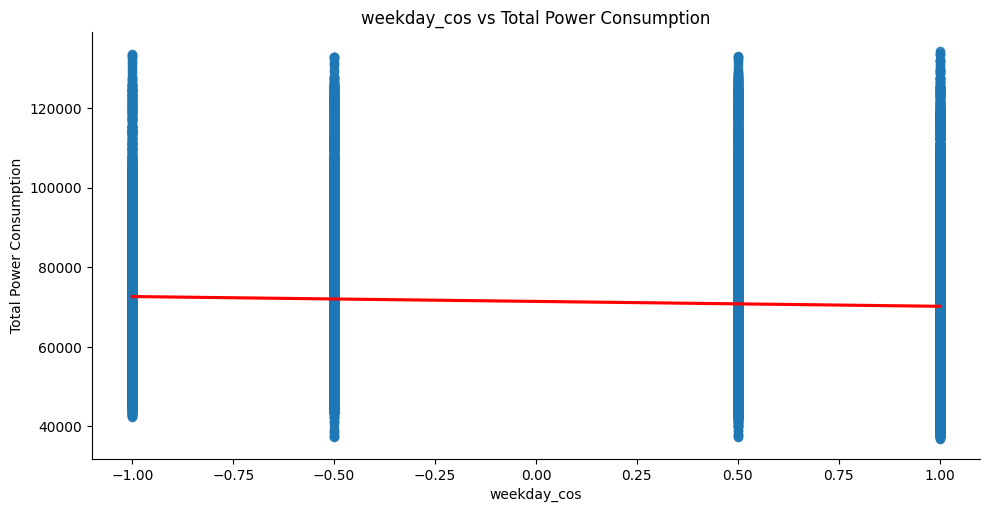

In [9]:
for feature in data.drop("Total Power Consumption", axis=1).columns:
    sns.lmplot(
        x=feature,
        y="Total Power Consumption",
        data=data,
        aspect=2,
        line_kws={"color": "red"},
    )
    plt.title(f"{feature} vs Total Power Consumption")
    plt.show()

According to scatter plots, it clearly shows that non of the features are in linear relationship with the target variable (*temperature* and *humidity* shows loose linear relationship, but it is not enough to consider them as linear).

## Baseline Model Selection and Training

With carefully prepared dataset, I pick the the Random Forest model as the baseline model (with default parameters). Before proceeding to the missing values experiments, I will train the model on the full dataset to have a reference point (with train-test split 80-20). I will use the mean absolute error and mean squared error as the metrics to evaluate the models. To make fair comparison, I will attempt 10 runs and average the results. For that I will create a custom training function.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_train, X_test, y_train, y_test, times=10):
    mse = []
    mae = []

    for _ in range(times):
        

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse.append(mean_squared_error(y_test, y_pred))
        mae.append(mean_absolute_error(y_test, y_pred))
    
    return mse, mae

rf = RandomForestRegressor()
X = data[data.columns[:-1]]
y = data["Total Power Consumption"]
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
rf_full_mse, rf_full_mae = evaluate_model(rf, X_train, X_test, y_train, y_test)

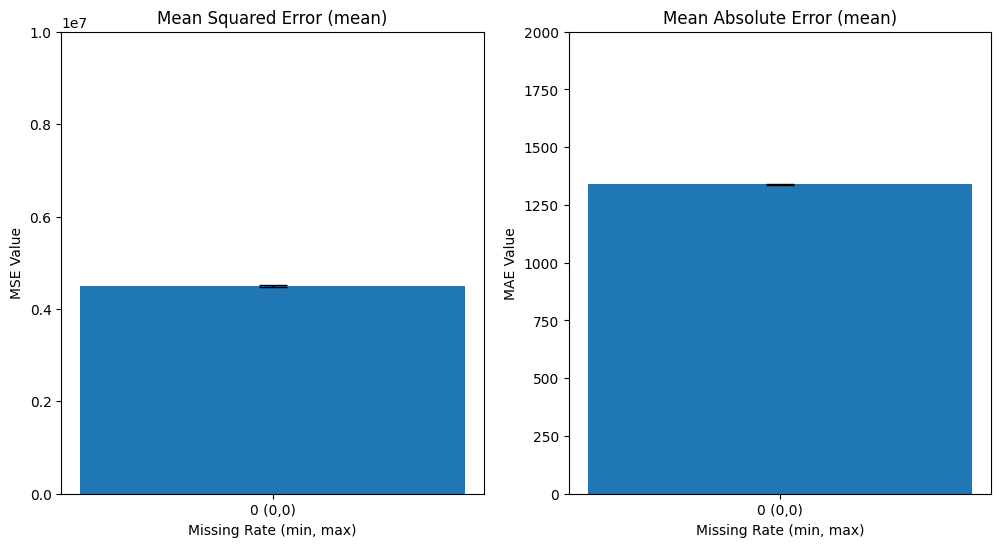

In [11]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar("0 (0,0)", np.mean(rf_full_mse), yerr=np.std(rf_full_mse), capsize=10)
plt.title('Mean Squared Error (mean)')
plt.ylabel('MSE Value')
plt.xlabel("Missing Rate (min, max)")
plt.ylim(0, 1e7)

plt.subplot(1, 2, 2)
plt.bar("0 (0,0)", np.mean(rf_full_mae), yerr=np.std(rf_full_mae), capsize=10)
plt.title('Mean Absolute Error (mean)')
plt.ylabel('MAE Value')
plt.xlabel("Missing Rate (min, max)")
plt.ylim(0, 2000)

plt.show()

## Missing Data Introduction

To test the missing data handling methods, I will introduce missing values to the dataset. I will use the following methods to introduce missing values at random (MAR). To make the experiments comprehensive, I will introduce missing values in different proportions: 1%, 5%, 10%, 25%. For each instance with missing value, the feature will be selected at random. I will extend it to the scenario where 2 features are missing at once and 1 to 5 features are missing at once.

In [12]:
def add_missing_values(data, missing_rate, min_features=1, max_features=1):
    # Picks proportion of samples in data (missing_rate) and in each selected converts randomly selected features (from min_features to max_features) to NaN
    data = data.copy()
    n_samples = int(data.shape[0] * missing_rate)
    samples = np.random.choice(data.index, n_samples, replace=False)
    features = np.random.randint(min_features, max_features + 1, n_samples)
    for sample, n_features in zip(samples, features):
        cols = np.random.choice(data.columns[:-1], n_features, replace=False)
        data.loc[sample, cols] = np.nan

    return data


missing_rates = [0.01, 0.05, 0.1, 0.25]
min_max_features = [(1, 1), (2, 2), (1, 5)]

Xs = []

missing_df_columns = (
    ["Missing Rate", "Min Features", "Max Features"]
    + list(X.columns)
    + ["Total"]
)
missing_df = pd.DataFrame(columns=missing_df_columns)

for min_feature, max_feature in min_max_features:
    for missing_rate in missing_rates:
        dataset = add_missing_values(X, missing_rate, min_feature, max_feature)
        Xs.append(dataset)

        missing = dataset.isnull().mean()
        total_missing = missing.mean()

        missing = missing.round(4)
        total_missing = total_missing.round(4)

        row = (
            [missing_rate, min_feature, max_feature]
            + list(missing)
            + [total_missing]
        )
        missing_df.loc[len(missing_df)] = row

display(Markdown(f"**Missing Data Overview**"), missing_df)

**Missing Data Overview**

,Missing Rate,Min Features,Max Features,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,weekday_sin,weekday_cos,Total
0,0.01,1.0,1.0,0.0008,0.0010,0.0008,0.0007,0.0008,0.0009,0.0008,0.0009,0.0010,0.0008,0.0009,0.0007,0.0,0.0008
1,0.05,1.0,1.0,0.0042,0.0047,0.0044,0.0047,0.0041,0.0041,0.0035,0.0038,0.0041,0.0041,0.0042,0.0042,0.0,0.0038
2,0.10,1.0,1.0,0.0086,0.0081,0.0074,0.0086,0.0081,0.0085,0.0083,0.0087,0.0086,0.0083,0.0080,0.0087,0.0,0.0077
3,0.25,1.0,1.0,0.0219,0.0200,0.0210,0.0212,0.0216,0.0206,0.0215,0.0204,0.0198,0.0209,0.0213,0.0198,0.0,0.0192
4,0.01,2.0,2.0,0.0019,0.0016,0.0019,0.0017,0.0015,0.0014,0.0016,0.0018,0.0015,0.0015,0.0016,0.0019,0.0,0.0015
5,0.05,2.0,2.0,0.0081,0.0078,0.0090,0.0089,0.0080,0.0076,0.0085,0.0089,0.0082,0.0080,0.0085,0.0085,0.0,0.0077
6,0.10,2.0,2.0,0.0163,0.0166,0.0175,0.0170,0.0154,0.0175,0.0157,0.0162,0.0163,0.0171,0.0176,0.0169,0.0,0.0154
7,0.25,2.0,2.0,0.0406,0.0414,0.0408,0.0420,0.0417,0.0437,0.0415,0.0401,0.0425,0.0417,0.0421,0.0418,0.0,0.0385
8,0.01,1.0,5.0,0.0023,0.0027,0.0026,0.0023,0.0025,0.0030,0.0023,0.0023,0.0023,0.0024,0.0023,0.0027,0.0,0.0023
9,0.05,1.0,5.0,0.0128,0.0127,0.0127,0.0131,0.0136,0.0129,0.0119,0.0129,0.0128,0.0118,0.0123,0.0126,0.0,0.0117


## Missing Data Handling: KNN Imputation

Since my scenario assumes possibly multiple missing features, we have a multivariate imputation problem. I will use the K-Nearst Neighbors imputation method to handle missing data. It is a method to estimate missing values in a dataset by leveraging the information available from the 'k' most similar instances (neighbors). KNN is inherently a non-parametric method used in both classification and regression; however, when it's used for imputation, the goal is to predict missing values based on the resemblance of other instances. The similarity between instances is calculated using a distance metric, such as Euclidean distance or Manhattan distance. I will use the KNNImputer from the scikit-learn library, with default distance metric (Euclidean) and weighted contribution of each neighbor, depending on the distance. I will experiment with different values of 'k' (number of neighbors) to find the best one.

### Hyperparameter Tuning (k)

Before the mine experiments, where I apply the imputation and score the baseline model, I will perform a hyperparameter tuning to find the best value of 'k' for the KNN imputer.

Iterating over datasets:   0%|          | 0/12 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

Iterating over k values:   0%|          | 0/10 [00:00<?, ?it/s]

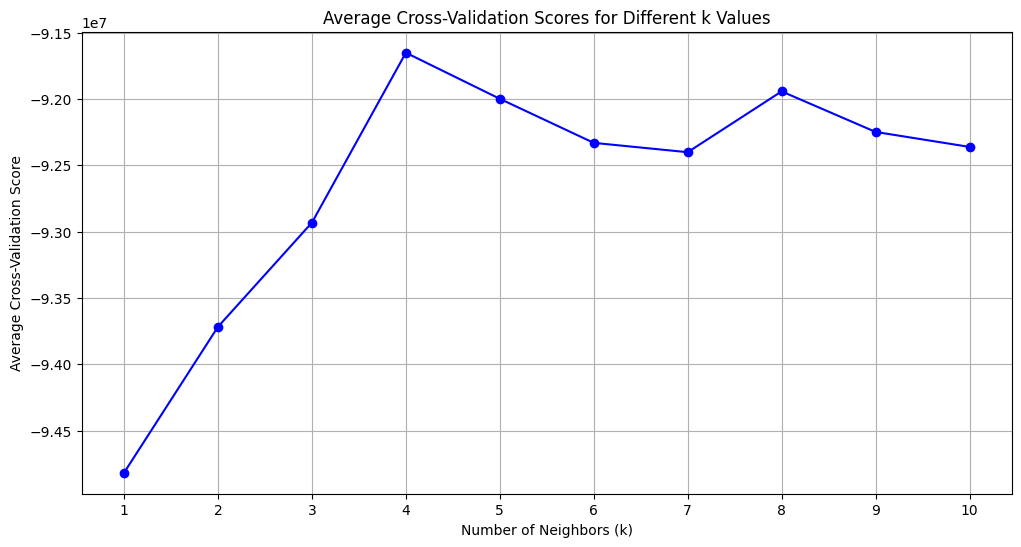

**Best k Value:**

4

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm

k_values = range(1, 11)
overall_cross_val_scores = np.zeros(len(k_values))

for X in tqdm(Xs, desc="Iterating over datasets"):
    for k in tqdm(k_values, desc="Iterating over k values"):
        imputer = KNNImputer(n_neighbors=k)
        model = make_pipeline(imputer, rf)
        scores = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
        overall_cross_val_scores[k - 1] += scores.mean()

overall_cross_val_scores /= len(Xs)

plt.figure(figsize=(12, 6))
plt.plot(k_values, overall_cross_val_scores, marker="o", linestyle="-", color="b")
plt.title("Average Cross-Validation Scores for Different k Values")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Average Cross-Validation Score")
plt.xticks(k_values)
plt.grid(True)
plt.show()

k = k_values[np.argmax(overall_cross_val_scores)]
display(Markdown(f"**Best k Value:**"), k)

We got the best results for $k=10$, however, $k=7$ offered very close results, and is less computationally expensive. I will use $k=7$ for the experiments.

### Main Experiments

With $k$ value set, I will run the main experiments and I will compare the results with the baseline model

In [14]:
k = 7
imputer = KNNImputer(n_neighbors=k)

mse = [rf_full_mse]
mae = [rf_full_mae]

for X in tqdm(Xs, desc="Iterating over datasets"):
    X_imputed = imputer.fit_transform(X)
    X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=test_size
    )
    rf_mse, rf_mae = evaluate_model(rf, X_train, X_test, y_train, y_test)
    mse.append(rf_mse)
    mae.append(rf_mae)

Iterating over datasets:   0%|          | 0/12 [00:00<?, ?it/s]

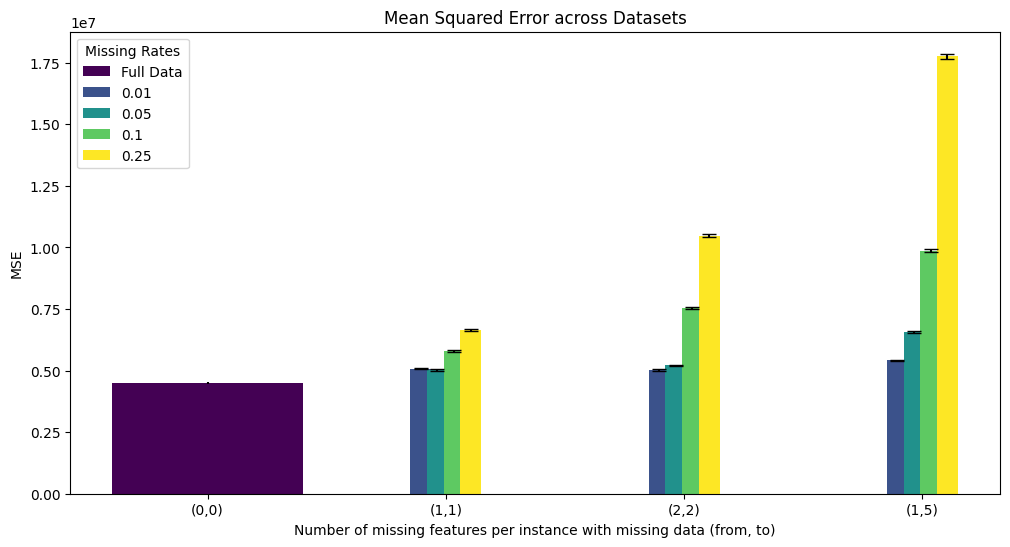

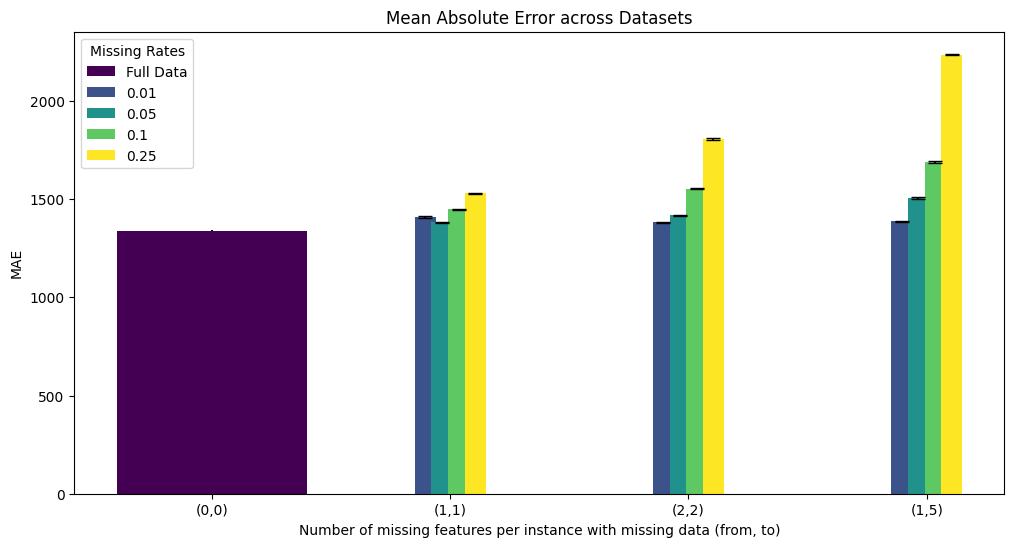

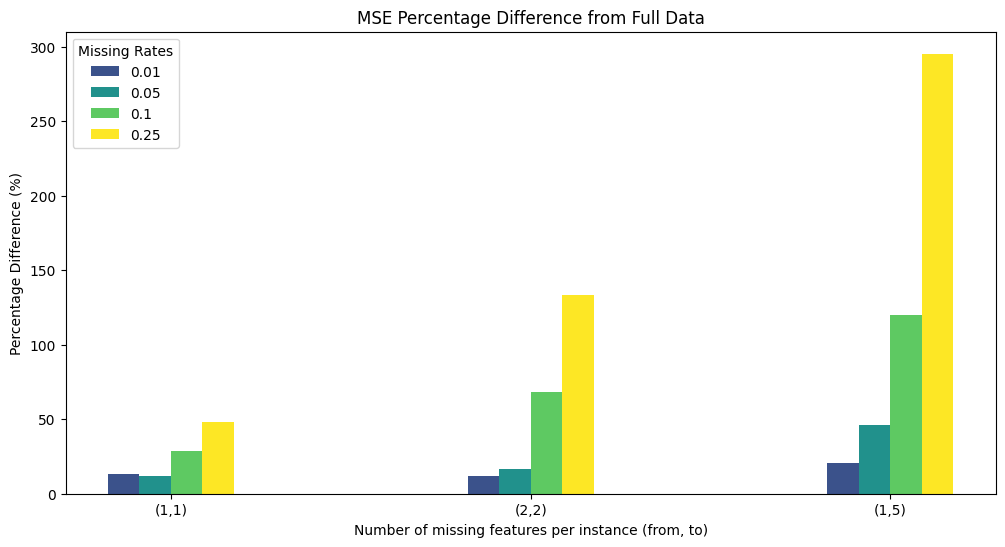

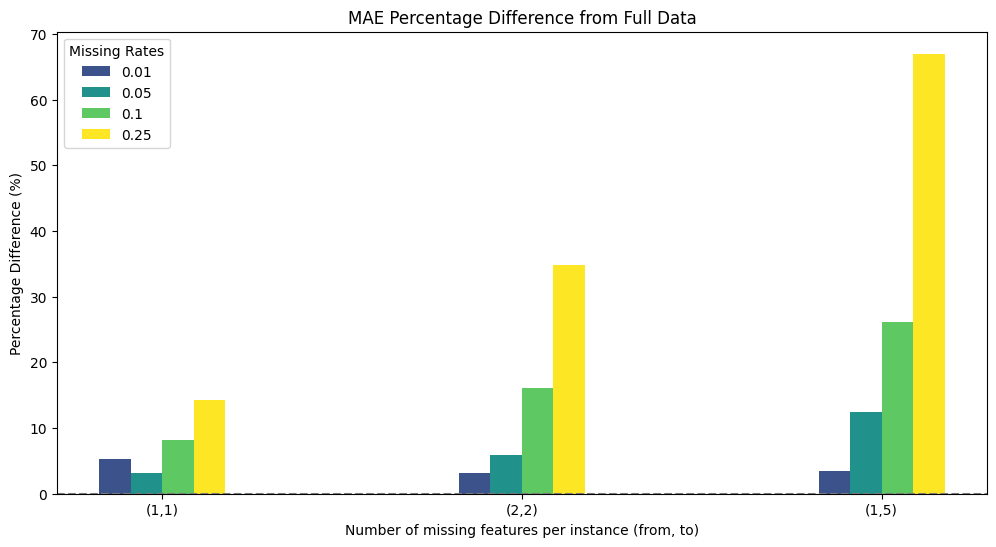

In [15]:
from matplotlib import colormaps

mse_means = [np.mean(m) for m in mse]
mse_stds = [np.std(m) for m in mse]
mae_means = [np.mean(m) for m in mae]
mae_stds = [np.std(m) for m in mae]

bar_width = 0.35
color_map = colormaps["viridis"]
colors = color_map(np.linspace(0, 1, len(missing_rates) + 1))

labels = [
    f"({min_feature},{max_feature})" for min_feature, max_feature in min_max_features
]
labels.insert(0, "(0,0)")
positions = np.arange(len(labels))

plt.figure(figsize=(12, 6))

for j, missing_rate in enumerate([0] + missing_rates):
    adjusted_positions = (
        positions - bar_width / 2 + j * bar_width / (len(missing_rates) + 1)
    )
    if j == 0:
        plt.bar(
            0,
            mse_means[0],
            yerr=mse_stds[0],
            label="Full Data",
            color=colors[j],
        )
    else:
        mse_group = [
            mse_means[i * len(missing_rates) + j] for i in range(len(min_max_features))
        ]
        mse_std_group = [
            mse_stds[i * len(missing_rates) + j] for i in range(len(min_max_features))
        ]
        plt.bar(
            adjusted_positions[1:],
            mse_group,
            yerr=mse_std_group,
            width=bar_width / (len(missing_rates)),
            capsize=5,
            label=f"{missing_rate}",
            color=colors[j],
        )

plt.title("Mean Squared Error across Datasets")
plt.ylabel("MSE")
plt.xticks(positions, labels)
plt.xlabel("Number of missing features per instance with missing data (from, to)")
plt.legend(title="Missing Rates")
plt.show()

plt.figure(figsize=(12, 6))

for j, missing_rate in enumerate([0] + missing_rates):
    adjusted_positions = (
        positions - bar_width / 2 + j * bar_width / (len(missing_rates) + 1)
    )
    if j == 0:
        plt.bar(
            0,
            mae_means[0],
            yerr=mae_stds[0],
            label="Full Data",
            color=colors[j],
        )
    else:
        mae_group = [
            mae_means[i * len(missing_rates) + j] for i in range(len(min_max_features))
        ]
        mae_std_group = [
            mae_stds[i * len(missing_rates) + j] for i in range(len(min_max_features))
        ]
        plt.bar(
            adjusted_positions[1:],
            mae_group,
            yerr=mae_std_group,
            width=bar_width / (len(missing_rates)),
            capsize=5,
            label=f"{missing_rate}",
            color=colors[j],
        )

plt.title("Mean Absolute Error across Datasets")
plt.ylabel("MAE")
plt.xticks(positions, labels)
plt.xlabel("Number of missing features per instance with missing data (from, to)")
plt.legend(title="Missing Rates")
plt.show()

mse_percentage_diff = [(m - mse_means[0]) / mse_means[0] * 100 for m in mse_means]
mae_percentage_diff = [(m - mae_means[0]) / mae_means[0] * 100 for m in mae_means]

bar_width = 0.35
color_map = colormaps["viridis"]
colors = color_map(np.linspace(0, 1, len(missing_rates) + 1))

labels = labels[1:] 
positions = positions[1:] 

plt.figure(figsize=(12, 6))

for j, missing_rate in enumerate(missing_rates):
    adjusted_positions = (
        positions - bar_width / 2 + (j + 0.5) * bar_width / len(missing_rates)
    )
    mse_diff_group = [
        mse_percentage_diff[i * len(missing_rates) + j + 1] for i in range(len(min_max_features))
    ]
    plt.bar(
        adjusted_positions,
        mse_diff_group,
        width=bar_width / len(missing_rates),
        capsize=5,
        label=f"{missing_rate}",
        color=colors[j + 1]
    )

plt.title("MSE Percentage Difference from Full Data")
plt.ylabel("Percentage Difference (%)")
plt.xticks(positions, labels)
plt.xlabel("Number of missing features per instance (from, to)")
plt.legend(title="Missing Rates")
plt.show()

plt.figure(figsize=(12, 6))

for j, missing_rate in enumerate(missing_rates):
    adjusted_positions = (
        positions - bar_width / 2 + (j + 0.5) * bar_width / len(missing_rates)
    )
    mae_diff_group = [
        mae_percentage_diff[i * len(missing_rates) + j + 1] for i in range(len(min_max_features))
    ]
    plt.bar(
        adjusted_positions,
        mae_diff_group,
        width=bar_width / len(missing_rates),
        capsize=5,
        label=f"{missing_rate}",
        color=colors[j + 1]
    )

plt.title("MAE Percentage Difference from Full Data")
plt.ylabel("Percentage Difference (%)")
plt.xticks(positions, labels)
plt.xlabel("Number of missing features per instance (from, to)")
plt.axhline(0, color='grey', linestyle='--')
plt.legend(title="Missing Rates")
plt.show()

No surprise, overall trend is that the more data is missing, the bigger errors (i.e. worse accuracy) we get. However, the KNN imputation method seems to handle the missing data quite well, as the errors are not significantly higher than the baseline model for small in case of small deficiencies. No matter how many features are missing (considering it is reasonable amount compared to the number of features, here at most 5 out of 13), when only 1% of data is missing, the errors are negligible. For 5% of missing data, the errors are negligible when only 1 feature is missing, while 2 and 1 to 5 scenario still provided decent result for MAE (increase in errors up to 10%) but the MSE increase is alarming. This indicates that while overall value of errors not increase much (MAE), sometimes there are significant errors (MSE is sensitive to large errors). For 10% of missing data, the errors are still acceptable, if only one feature is missing. Rest of the experiment scenarios gave results unacceptable. The more sophisticated imputation methods should be considered in such cases.